In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import baltic as bt
import os
from matplotlib import gridspec
from collections import Counter
import treeswift
from matplotlib.lines import Line2D

from IPython.display import display
from utils import *

# Count up reversions, compare to rest of substitutions, using fasta

In [2]:
fasta_path = '20210903.WHO.masked.fasta'
recMRCA_path = 'recMRCA.BANAL.masked.fasta'
hu1_path = 'hu1.fasta'

fasta = readFASTA(fasta_path)
recMRCA = readFASTA(recMRCA_path)['recMRCA']
hu1 = readFASTA(hu1_path)['hCoV-19/Wuhan/Hu-1/2019']

fullReversions = compare_seqs(hu1, recMRCA)
partReversions = [x[1:] for x in fullReversions]

# On the tree

In [3]:
nexusPath = 'divergence_tree.nexus'
tree = treeswift.read_tree_nexus(nexusPath)['tree1']

In [4]:
tree_substitutions = []
for n in tree.traverse_preorder():
    if 'mutations' in n.edge_params:
        mutations = [x for x in n.edge_params.split(',date')[0].split('=')[1].strip('"').split(',') if x]
        tree_substitutions += mutations
        
num_reversions = len(set([x for x in tree_substitutions if x in fullReversions]))
num_substitutions = len(set([x for x in tree_substitutions if (x[-1] in 'ACGT' and x[0] in 'ACGT') and x not in fullReversions]))
num_reversions, num_substitutions, num_reversions/len(fullReversions), num_substitutions/(29515 - len(fullReversions))

(23, 631, 0.06036745406824147, 0.02165854328276241)

#### C>T bias among reversions?

In [5]:
Counter([x[0] + x[-1] for x in set(tree_substitutions) if x in fullReversions])

Counter({'CT': 19, 'GA': 1, 'TC': 3})

# Edit tree so that it only has reversions

In [6]:
# divergence_tree = 'divergence_tree.nexus'
# reversion_tree = 'reversion_tree.nexus'
# tree_reversions = []

# with open(reversion_tree, 'w') as f:
#     for line in open(divergence_tree):
#         if line.startswith(' Tree'):
#             l = line.split('"')
#             new_l = ''
#             for index, _ in enumerate(l):
#                 if ',' in _ and '(' not in _ and ')' not in _ and '[' not in _ and ']' not in _:
#                     muts = _.split(',')
#                     muts = [x for x in muts if x[1:] in partReversions]
#                     new_l += (','.join(muts))
#                 else:
#                     if len(_) > 10:
#                         new_l += _
#                     else:
#                         if _ and _[1:] in partReversions:
#                             new_l += _
#                         else:
#                             new_l += ''                              
#                 if index != (len(l)-1):
#                     new_l += '"'
#             f.write(new_l)
#         else:
#             f.write(line)

# Plot tree

In [7]:
cmap = ["94d2bd","ee9b00","ca6702","bb3e03","ae2012"]
cmap = ['#' + x for x in cmap]

import tol_colors as tc
cset = tc.tol_cset('muted')



Tree height: 0.001270
Tree length: 0.024575
annotations present

Numbers of objects in tree: 919 (132 nodes and 787 leaves)



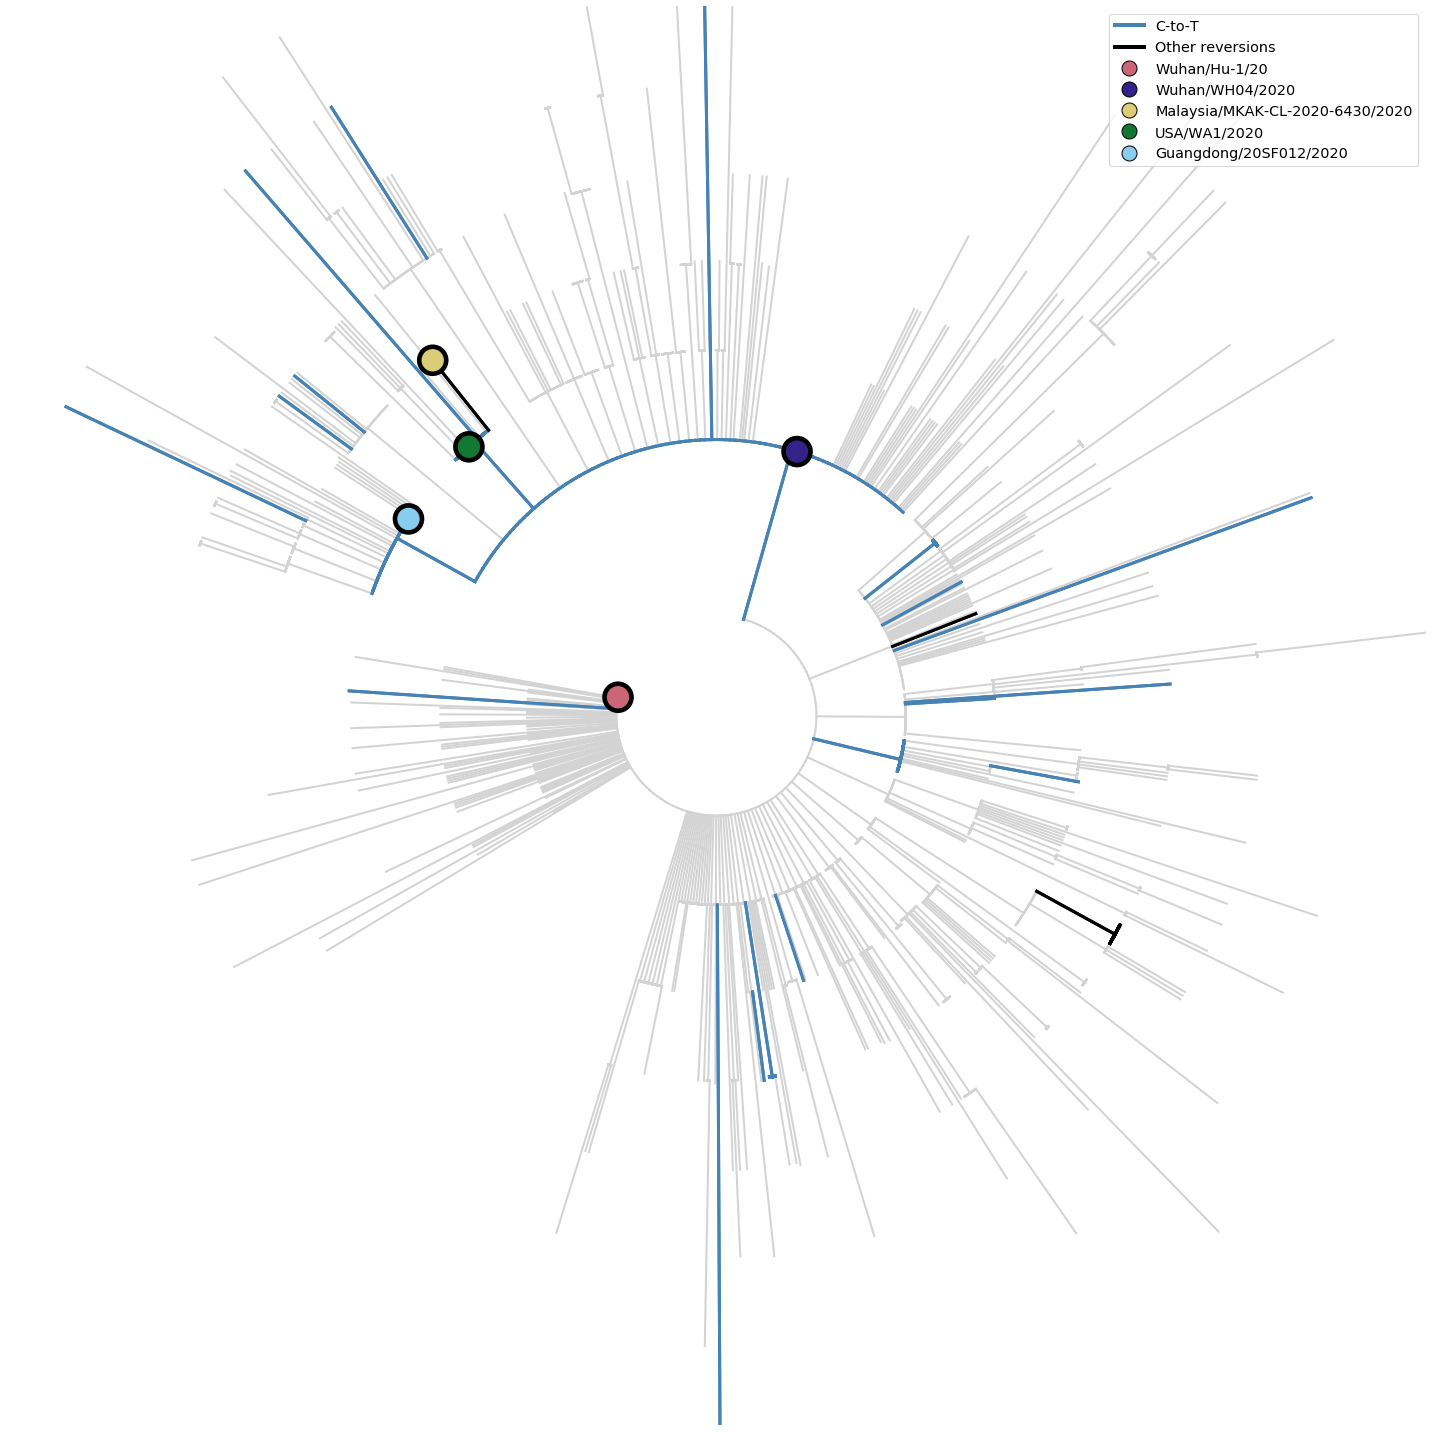

In [8]:
nexusPath = 'reversion_tree.nexus'
myTree = bt.loadNewick(nexusPath, sortBranches= False) # Please note the change here
myTree.treeStats() ## report stats about tree
myTree.sortBranches(descending = False, sortByHeight= False) # Please note the change here
target_important = lambda k: (k.is_leaf() and k.name in important_seqs)

dates = []
mutations = []
important_seqs = []
for k in myTree.Objects:
    if 'mutations' in k.traits:
        k.mutations = k.traits['mutations']
    else:
        k.mutations = None
    mutations.append(k.mutations)
    
    if k.is_leaf():
        if '20SF012' in k.name:
            important_seqs.append(k.name)
        elif '/WH04' in k.name:
            important_seqs.append(k.name)
        elif 'Hu-1' in k.name:
            important_seqs.append(k.name)
        elif 'WA1' in k.name:
            important_seqs.append(k.name)
        elif 'MKAK-CL-2020-6430' in k.name: # super revertant
            important_seqs.append(k.name)

colourFull=lambda k: 'steelblue' if k.mutations and k.mutations[0] == 'C' else ('black' if k.mutations else 'lightgrey')
colourTransparent=lambda k: 'steelblue' if k.mutations and k.mutations[0] == 'C' else ('black' if k.mutations else (0,0,0,0))
colourImportantSeqs=lambda k: cset[important_seqs.index(k.name)]
widths=lambda k: 3 if k.mutations else 2

f,ax = plt.subplots(figsize=(20,20),facecolor='w')

myTree.plotCircularTree(ax,circStart=.8,circFrac=.98,colour=colourFull,width=widths,inwardSpace=0.03*myTree.treeHeight, precision=100) ## tree starts a quarter of the way through a circle and occupies its entirety, 5% of tree height is left as space from center, inward space is positive, therefore tree radiates outwards
myTree.plotCircularTree(ax,circStart=.8,circFrac=.98,colour=colourTransparent,width=widths,inwardSpace=0.03*myTree.treeHeight, precision=100) ## tree starts a quarter of the way through a circle and occupies its entirety, 5% of tree height is left as space from center, inward space is positive, therefore tree radiates outwards
myTree.plotCircularPoints(ax,target=target_important, outline=True, circStart=0.8, circFrac=0.98,colour=colourImportantSeqs,inwardSpace=0.03*myTree.treeHeight,size=500)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_aspect(1)
ax.axis("off")

# legend
custom_lines = [Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
custom_labels = ['C-to-T', 'Other reversions']

for ctr, i in enumerate(important_seqs):
    custom_lines.append(Line2D([0], [0], marker='o', color='w', label=i, markeredgecolor='black', markerfacecolor=cset[ctr], markersize=15))
    custom_labels.append(important_seqs[ctr].split('|')[0].strip('hCoV-19/'))


ax.legend(custom_lines, custom_labels, fontsize='x-large')


 
plt.tight_layout()
plt.show()
# plt.close()

# Other triple+ revertants?

In [9]:
num_trip_revertants = 0
trip_revertant_subs = []
for key in fasta:
    seq = fasta[key]
    temp_subs = compare_seqs(hu1, seq)
    if len(set(temp_subs).intersection(set(fullReversions))) > 2:
        num_trip_revertants += 1
#         trip_revertant_subs.append(sorted(list(temp_subs)))
        trip_revertant_subs.append(sorted(list(set(temp_subs).intersection(set(fullReversions)))))

In [10]:
Counter([str(x) for x in trip_revertant_subs])

Counter({"['C29095T', 'C8782T', 'T28144C']": 37,
         "['C24023T', 'C8782T', 'T28144C']": 3,
         "['C18060T', 'C8782T', 'T28144C']": 16,
         "['C25000T', 'C8782T', 'T28144C']": 1,
         "['C18060T', 'C8782T', 'T28144C', 'T6025C']": 1,
         "['C4276T', 'C8782T', 'T28144C']": 1,
         "['C22747T', 'C8782T', 'T28144C']": 1,
         "['C23638T', 'C29095T', 'C8782T', 'T28144C']": 1,
         "['C18060T', 'C2485T', 'C8782T', 'T28144C']": 1})